# Check which window_size, alpha parameters tend to give best R^2

In [1]:
library(CpGWAS)

In [2]:
scaff_paths <- list.files("../output/", pattern = "rds", full.names = TRUE)

In [3]:
scaff_paths <- scaff_paths[!grepl("1000000", scaff_paths)]

In [4]:
scaff_paths

[1] "../output//libd_chr1-chr1_AA-libd_chr1-chr1_AA-1001000-1001999-static-1corestotal-1corepera-20240201-164244.rds"
[2] "../output//libd_chr1-chr1_AA-libd_chr1-chr1_AA-1004000-1004999-static-1corestotal-1corepera-20240201-164247.rds"
[3] "../output//libd_chr1-chr1_AA-libd_chr1-chr1_AA-1005000-1005999-static-1corestotal-1corepera-20240201-164248.rds"

In [5]:
convertToDataFrame <- function(object) {
  if (!inherits(object, "MethylationScaff")) {
    stop("The object must be of class 'MethylationScaff'.")
  }

  modelsList <- lapply(object@models, function(model) {
    data.frame(
      scaffoldIdentifier = object@scaffoldIdentifier,  # Scaffold identifier is the same for all models
      methylationPosition = model@methylationPosition,
      windowSize = model@windowSize,
      nSNPs = model@n_SNPs,
      cor = model@evaluation_results['cor'],
      mse = model@evaluation_results['mse'],
      alpha = model@alpha,
      lambda = model@lambda
    )
  })

  do.call("rbind", modelsList)
}

In [6]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [7]:
df <- data.frame()

In [8]:
for(scaff_path in scaff_paths){
    my_scaff <- readRDS(scaff_path)
    small_df <- convertToDataFrame(my_scaff)
    df <- bind_rows(df, small_df)
}

In [9]:
dim(df)

[1] 22768     8

In [25]:
length(levels(factor(df$methylationPosition)))

[1] 3000

In [22]:
dim(df)[1]/(8*5)

[1] 569.2

What percentage of models have all coefficients dropped during regularization?

In [10]:
sum(is.na(df$cor))/dim(df)[1]

[1] 0.1553496

What if we limit to the best model for each positions?

## Which alpha, window_size tend to give most `NA`?

We get `NA` values for cor when all SNPs are dropped during regularization.

In [11]:
library(dplyr)
library(ggplot2)

# For alpha
na_percentage_alpha <- df %>%
  group_by(alpha) %>%
  summarise(PercentageNA = mean(is.na(cor)) * 100)

# For windowSize
na_percentage_windowSize <- df %>%
  group_by(windowSize) %>%
  summarise(PercentageNA = mean(is.na(cor)) * 100)


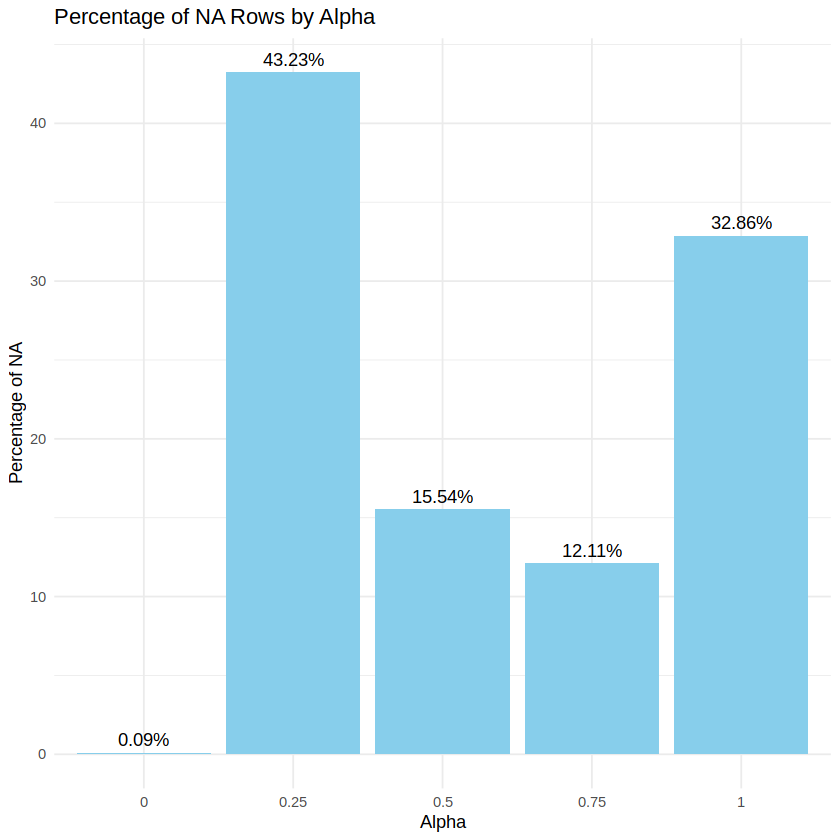

In [12]:
ggplot(na_percentage_alpha, aes(x = as.factor(alpha), y = PercentageNA)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  geom_text(aes(label = sprintf("%.2f%%", PercentageNA)), vjust = -0.5) +
  theme_minimal() +
  labs(title = "Percentage of NA Rows by Alpha", x = "Alpha", y = "Percentage of NA")


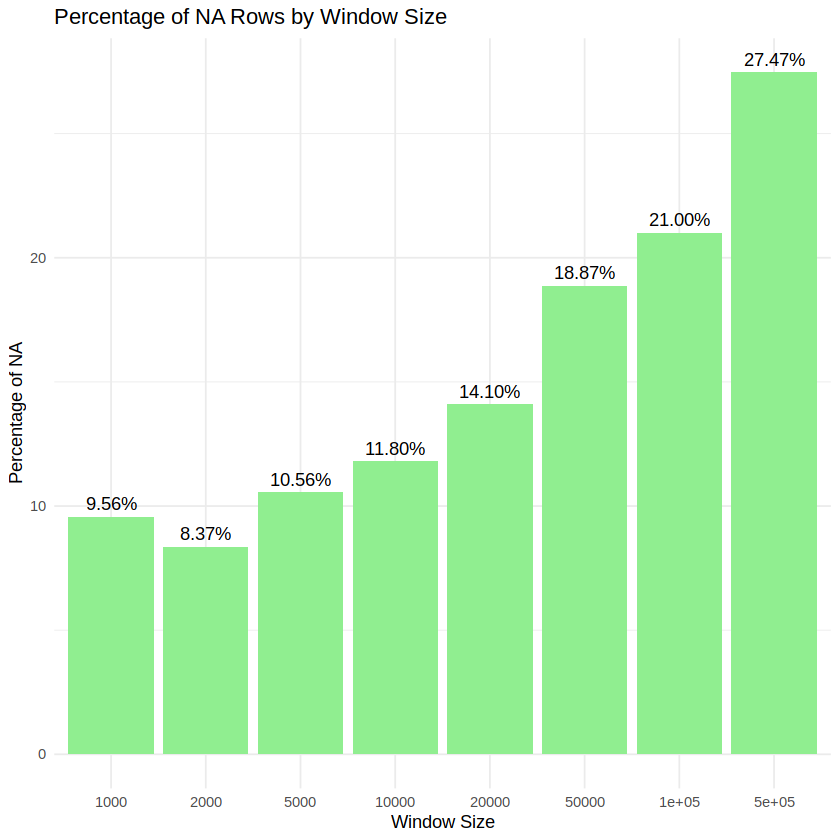

In [13]:
ggplot(na_percentage_windowSize, aes(x = as.factor(windowSize), y = PercentageNA)) +
  geom_bar(stat = "identity", fill = "lightgreen") +
  geom_text(aes(label = sprintf("%.2f%%", PercentageNA)), vjust = -0.5) +
  theme_minimal() +
  labs(title = "Percentage of NA Rows by Window Size", x = "Window Size", y = "Percentage of NA")


## See which have best `alpha`, `window_size` tend to give best R^2 (`cor1`)

In [14]:
library(dplyr)

# Assuming your data frame is named df
# filtered_df <- df %>%
#   filter(!is.na(cor)) %>%
#   group_by(methylationPosition) %>%
#   slice(which.max(cor))


In [26]:
filtered_df <- df

Which have NA for all?

In [27]:
na_positions <- df %>%
  group_by(methylationPosition) %>%
  filter(all(is.na(cor))) %>%
  summarise() %>%
  pull(methylationPosition)


In [28]:
length(na_positions)

[1] 1

In [29]:
na_positions_df <- df %>%
  filter(methylationPosition %in% na_positions)


In [30]:
na_positions

[1] 88530660

Warning message:
“Removed 3537 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 3537 rows containing missing values (`geom_point()`).”


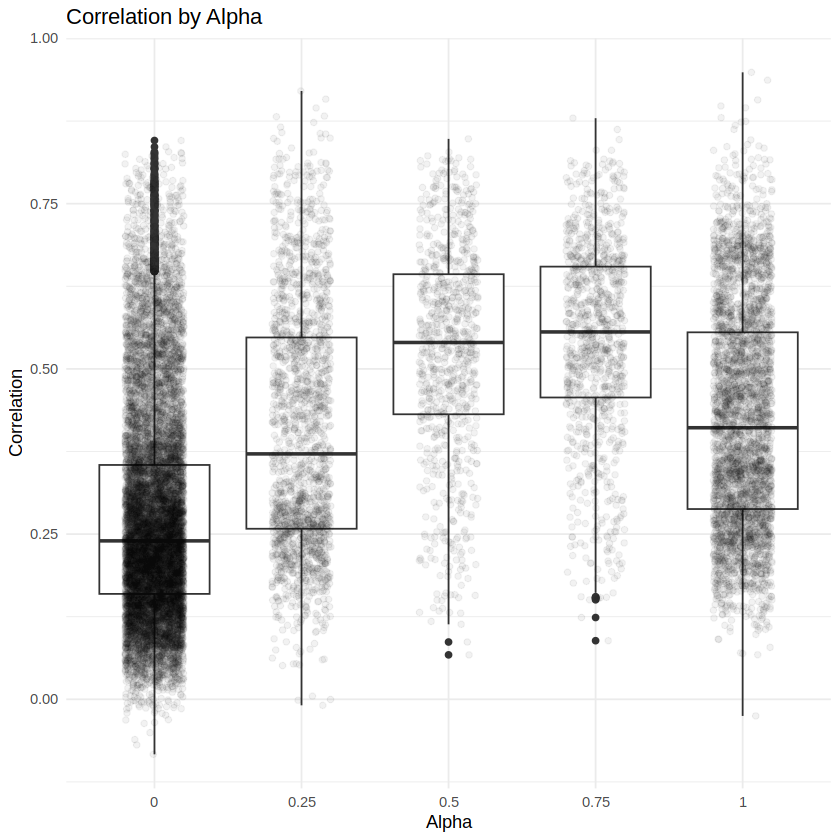

In [34]:
library(ggplot2)

ggplot(filtered_df, aes(x = as.factor(alpha), y = cor)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.05) +
  theme_minimal() +
  labs(title = "Correlation by Alpha", x = "Alpha", y = "Correlation")


Warning message:
“Removed 3537 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 3537 rows containing missing values (`geom_point()`).”


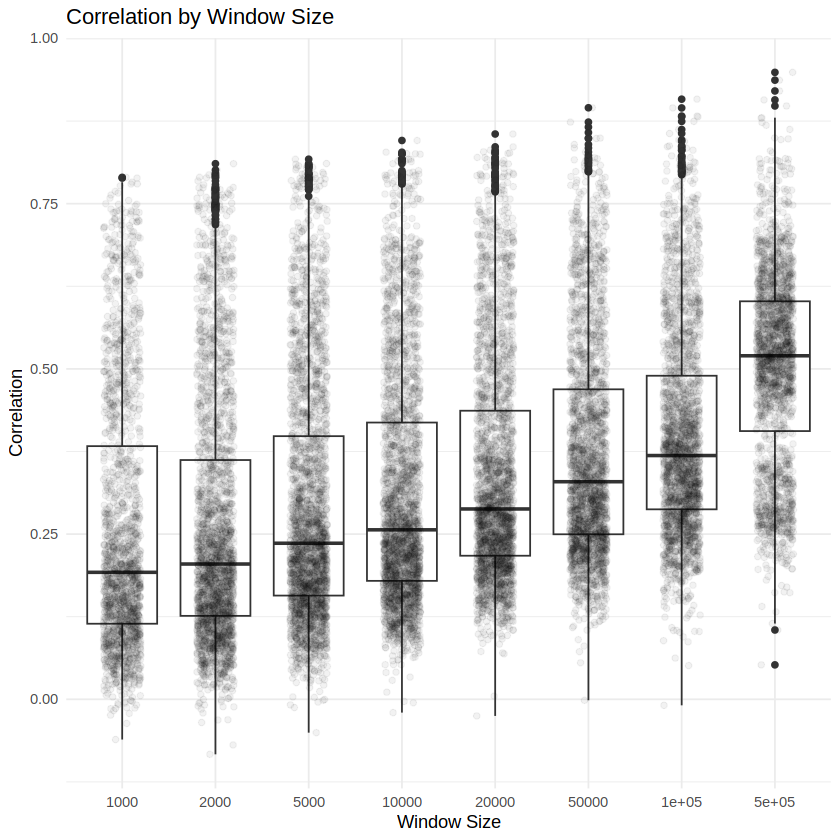

In [35]:
ggplot(filtered_df, aes(x = as.factor(windowSize), y = cor)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.05) +
  theme_minimal() +
  labs(title = "Correlation by Window Size", x = "Window Size", y = "Correlation")